In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import datasets,transforms

In [ ]:
# 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 加载MNIST训练集和测试集
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# 创建数据加载器
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 63808216.80it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 64468171.27it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 20813444.67it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8425709.32it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# 定义全连接神经网络模型
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# 初始化模型、损失函数和优化器
model = SimpleMLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



Epoch [1/10], Loss: 0.3843, Accuracy: 88.76%
Epoch [2/10], Loss: 0.1959, Accuracy: 94.22%
Epoch [3/10], Loss: 0.1416, Accuracy: 95.81%
Epoch [4/10], Loss: 0.1156, Accuracy: 96.56%
Epoch [5/10], Loss: 0.0951, Accuracy: 97.15%
Epoch [6/10], Loss: 0.0831, Accuracy: 97.47%
Epoch [7/10], Loss: 0.0737, Accuracy: 97.67%
Epoch [8/10], Loss: 0.0688, Accuracy: 97.88%
Epoch [9/10], Loss: 0.0605, Accuracy: 98.09%
Epoch [10/10], Loss: 0.0561, Accuracy: 98.21%


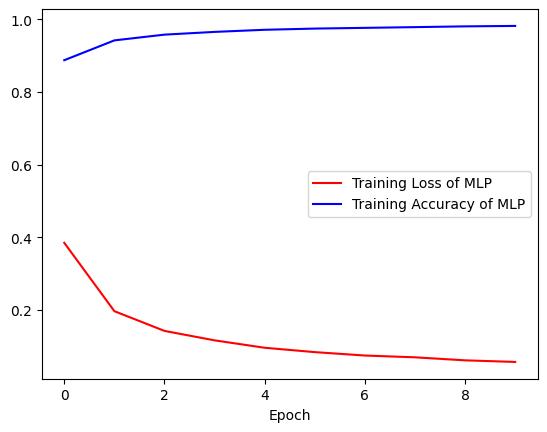

In [ ]:
#记录训练过程中的损失和准确度
train_losses = []
train_accuracies = []

# 训练模型
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # 计算训练准确度和损失
    train_accuracy = correct / total
    train_loss = running_loss / len(train_loader)

    # 保存训练过程中的准确度和损失
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy * 100:.2f}%')

# 绘制学习曲线
plt.plot(train_losses, label='Training Loss of MLP', color='r')
plt.plot(train_accuracies, label='Training Accuracy of MLP', color='b')


# 添加图例
plt.legend()

# 显示图形
plt.xlabel('Epoch')
plt.show()


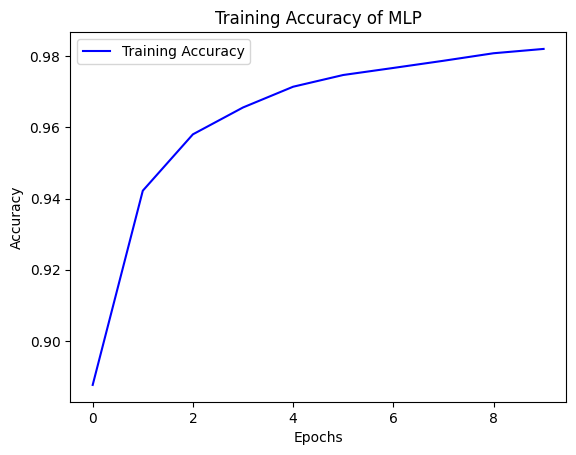

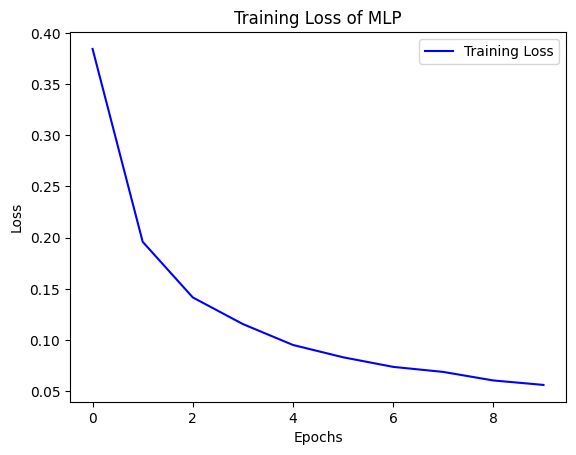

In [ ]:
# 绘制训练和验证的准确率曲线
plt.plot(train_accuracies, label='Training Accuracy', color='b')
#plt.plot(val_accuracies, label='Validation Accuracy', color='r')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy of MLP')
plt.show()

# 绘制训练和验证的损失值曲线
plt.plot(train_losses, label='Training Loss', color='b')
#plt.plot(val_losses, label='Validation Loss', color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss of MLP')
plt.show()

In [ ]:
# 模型可视化
from torchsummary import summary

# 显示模型结构
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              ReLU-3                  [-1, 128]               0
            Linear-4                   [-1, 10]           1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.39
Estimated Total Size (MB): 0.40
----------------------------------------------------------------


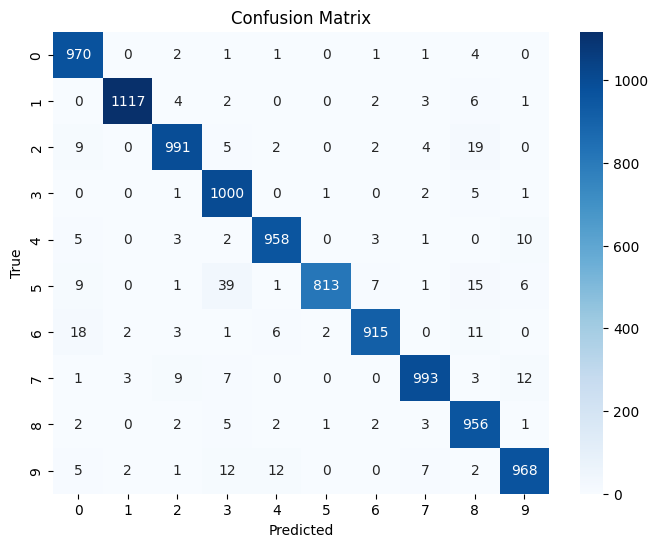

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
# 混淆矩阵分析
model.eval()
all_labels, all_preds = [], []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.numpy())
        all_preds.extend(predicted.numpy())

# 计算混淆矩阵
cm = confusion_matrix(all_labels, all_preds)

# 可视化混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
import itertools
import numpy as np

# 绘制混淆矩阵
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Input
    - cm : 计算出的混淆矩阵的值
    - classes : 混淆矩阵中每一行每一列对应的列
    - normalize : True:显示百分比, False:显示个数
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
attack_types = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]



Normalized confusion matrix
[[9.89795918e-01 0.00000000e+00 2.04081633e-03 1.02040816e-03
  1.02040816e-03 0.00000000e+00 1.02040816e-03 1.02040816e-03
  4.08163265e-03 0.00000000e+00]
 [0.00000000e+00 9.84140969e-01 3.52422907e-03 1.76211454e-03
  0.00000000e+00 0.00000000e+00 1.76211454e-03 2.64317181e-03
  5.28634361e-03 8.81057269e-04]
 [8.72093023e-03 0.00000000e+00 9.60271318e-01 4.84496124e-03
  1.93798450e-03 0.00000000e+00 1.93798450e-03 3.87596899e-03
  1.84108527e-02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.90099010e-04 9.90099010e-01
  0.00000000e+00 9.90099010e-04 0.00000000e+00 1.98019802e-03
  4.95049505e-03 9.90099010e-04]
 [5.09164969e-03 0.00000000e+00 3.05498982e-03 2.03665988e-03
  9.75560081e-01 0.00000000e+00 3.05498982e-03 1.01832994e-03
  0.00000000e+00 1.01832994e-02]
 [1.00896861e-02 0.00000000e+00 1.12107623e-03 4.37219731e-02
  1.12107623e-03 9.11434978e-01 7.84753363e-03 1.12107623e-03
  1.68161435e-02 6.72645740e-03]
 [1.87891441e-02 2.08768267e-0

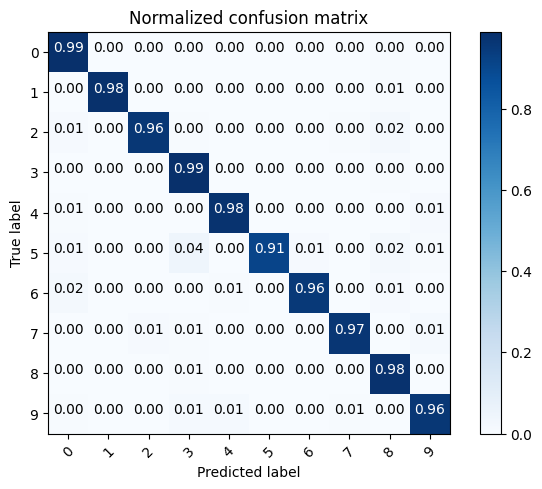

In [ ]:
plot_confusion_matrix(cm, classes=attack_types, normalize=True, title='Normalized confusion matrix')

In [ ]:
from sklearn.metrics import f1_score

# 假设 all_preds 是预测标签，all_labels 是真实标签
# 计算 Macro-averaging 的 F1-score
macro_f1 = f1_score(all_labels, all_preds, average='macro')
print(f'Macro-averaging F1-score: {macro_f1:.4f}')

# 计算 Micro-averaging 的 F1-score
micro_f1 = f1_score(all_labels, all_preds, average='micro')
print(f'Micro-averaging F1-score: {micro_f1:.4f}')

# 计算每个类别的 F1-score
per_class_f1 = f1_score(all_labels, all_preds, average=None)
print('Per-class F1-score:')
for i, f1 in enumerate(per_class_f1):
    print(f'Class {i}: {f1:.4f}')


Macro-averaging F1-score: 0.9676
Micro-averaging F1-score: 0.9681
Per-class F1-score:
Class 0: 0.9705
Class 1: 0.9889
Class 2: 0.9673
Class 3: 0.9597
Class 4: 0.9756
Class 5: 0.9514
Class 6: 0.9683
Class 7: 0.9721
Class 8: 0.9584
Class 9: 0.9641


In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9681


In [ ]:
from sklearn.metrics import classification_report

# 在测试集上进行预测
# 请确保已经获取了all_preds和all_labels

# 生成分类报告
report = classification_report(all_labels, all_preds)
print(report)



              precision    recall  f1-score   support

           0       0.95      0.99      0.97       980
           1       0.99      0.98      0.99      1135
           2       0.97      0.96      0.97      1032
           3       0.93      0.99      0.96      1010
           4       0.98      0.98      0.98       982
           5       1.00      0.91      0.95       892
           6       0.98      0.96      0.97       958
           7       0.98      0.97      0.97      1028
           8       0.94      0.98      0.96       974
           9       0.97      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [ ]:
from sklearn.metrics import precision_score, recall_score

# 计算每个类别的精确率和召回率
precision = precision_score(all_labels, all_preds, average=None)
recall = recall_score(all_labels, all_preds, average=None)

# 打印每个类别的精确率和召回率
for class_label in range(10):  # num_classes 是类别的数量
    print(f"Class {class_label} - Precision: {precision[class_label]}, Recall: {recall[class_label]}")


Class 0 - Precision: 0.9519136408243376, Recall: 0.9897959183673469
Class 1 - Precision: 0.9937722419928826, Recall: 0.9841409691629956
Class 2 - Precision: 0.9744346116027532, Recall: 0.9602713178294574
Class 3 - Precision: 0.931098696461825, Recall: 0.9900990099009901
Class 4 - Precision: 0.9755600814663951, Recall: 0.9755600814663951
Class 5 - Precision: 0.9951040391676866, Recall: 0.9114349775784754
Class 6 - Precision: 0.9817596566523605, Recall: 0.9551148225469729
Class 7 - Precision: 0.9783251231527094, Recall: 0.9659533073929961
Class 8 - Precision: 0.9363369245837414, Recall: 0.9815195071868583
Class 9 - Precision: 0.968968968968969, Recall: 0.9593657086223984
